In [1]:
import math
import random
import numpy as np
import copy
import itertools
import time
import matplotlib.pyplot as plt

In [124]:
class LocalSearch:
    def __init__(self, demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities):
        '''Initialize the parameters of the local search
        
        '''
        self.demand_nodes = demand_nodes
        self.facility_nodes = facility_nodes
        self.T = T
        self.demands = demands
        self.distances = distances
        self.max_distance = max_distance
        self.num_of_facilities = num_of_facilities
        self.last_move = None
        
        self.best_solution = self.generate_initial_state_random()
        self.best_value = self.solution_value(self.best_solution)
        
        self.curr_solution = None
        self.curr_value = None
        self.curr_solution_close_neighbours = None
        self.curr_solution_close_facility_count = None


    def initialize_close_facility_count(self):
        self.close_facility_count = [0 for i in range(len(self.curr_solution))]
        #print(self.close_facility_count)
        num_of_nodes = len(self.demand_nodes)
        
        for ind, is_facility in enumerate(self.curr_solution):
            if is_facility:
                #print(ind)
                node = ind % num_of_nodes
                time_period = ind // num_of_nodes
                for neighbour in self.curr_solution_close_neighbours[node]:
                    #print(ind, neighbour)
                    self.close_facility_count[time_period*num_of_nodes + neighbour] += 1
                    
        #print(self.close_facility_count)
        

    def initialize_close_neighbours(self):
        num_of_nodes = len(self.demand_nodes)
        self.curr_solution_close_neighbours = [[] for i in range(num_of_nodes)]
        
        for node, distances in enumerate(self.distances):
            for neighbour, distance in enumerate(distances):
                if distance < self.max_distance:
                    self.curr_solution_close_neighbours[node].append(neighbour)
        #print(self.curr_solution_close_neighbours)
        
    def get_real_node_and_time_period_from_solution_node(self, ind):
        num_of_nodes = len(self.demand_nodes)
        node = ind % num_of_nodes
        time_period = ind // num_of_nodes
        return node, time_period
    
    def turn_facility_off(self, shut_down_facility):
        num_of_nodes = len(self.demand_nodes)
        node, time_period = self.get_real_node_and_time_period_from_solution_node(shut_down_facility)
        for neighbour in self.curr_solution_close_neighbours[node]:
            self.close_facility_count[time_period*num_of_nodes+neighbour] -= 1
            assert(self.close_facility_count[time_period*num_of_nodes+neighbour]>=0)
            if self.close_facility_count[time_period*num_of_nodes+neighbour] == 0:
                self.curr_value -= self.demands[neighbour][time_period] 
    
    def turn_facility_on(self, started_facility):
        num_of_nodes = len(self.demand_nodes)
        node, time_period = self.get_real_node_and_time_period_from_solution_node(started_facility)
        for neighbour in self.curr_solution_close_neighbours[node]:
            if self.close_facility_count[time_period*num_of_nodes+neighbour] == 0:
                self.curr_value += self.demands[neighbour][time_period]
            self.close_facility_count[time_period*num_of_nodes+neighbour] += 1
        
        
    def generate_neighbour_and_update_solution_value(self):
        self.generate_neighbour_2(self.curr_solution)
        
        shut_down_facility = self.last_move[0]
        started_facility = self.last_move[1]
        
        # self.last_move[0] = solution_i koji se postavlja na False
        # treba proci kroz sve bliske susede i smanjiti im count, ako postaje 0 smanjiti solution_value
        self.turn_facility_off(self.last_move[0])
        
        # self.last_move[1] = solution_j koji se postavlja na True
        # treba proci kroz sve bliske susede i povecati im count, ako je bio nula povecati solution value
        self.turn_facility_on(self.last_move[1])
        
        
    def solution_initialize_values(self, verbose=False):
        if verbose:
            print("OOOz")
            for i in self.curr_solution:
                print(i)
            print("OOO")
            
        num_of_nodes = len(self.demand_nodes)
        value = 0
        
        for ind, is_facility in enumerate(self.curr_solution):
            node = ind % num_of_nodes
            time_period = ind // num_of_nodes
            
            for i in range(num_of_nodes*time_period, num_of_nodes*(time_period+1)):
                if self.curr_solution[i] and self.distances[i-num_of_nodes*time_period][node] < self.max_distance:
                    value += self.demands[node][time_period]
                    if verbose:
                        print(node, time_period,i, self.curr_solution[i])
                    break
        
        self.curr_value = value
        self.initialize_close_neighbours()
        self.initialize_close_facility_count()
                    
        return value
    
    def solution_value(self, solution, verbose=False):
        if verbose:
            print("OOO")
            for i in solution:
                print(i)
            print("OOO")
            
        num_of_nodes = len(self.demand_nodes)
        value = 0
        
        for ind, is_facility in enumerate(solution):
            node = ind % num_of_nodes
            time_period = ind // num_of_nodes
            
            for i in range(num_of_nodes*time_period, num_of_nodes*(time_period+1)):
                if solution[i] and self.distances[i-num_of_nodes*time_period][node] < self.max_distance:
                    value += self.demands[node][time_period]
                    if verbose:
                        print(node, time_period,i, solution[i])
                    break
                    
        return value
        

    def generate_initial_state_random(self):
        solution = [False] * (len(self.demand_nodes)*self.T)
        if num_of_facilities >= len(solution):
            raise Exception("Number of facilities to allocate must be smaller than possible facility places")
        
        inds = random.sample(range(0, len(solution)), self.num_of_facilities)
        for i in inds:
            solution[i] = True
            
        return solution
        
    def generate_neighbour_2(self, solution):
        self.last_move = [0, 0]
        
        while True:
            i = random.randrange(0, len(self.curr_solution))
            if solution[i]:
                solution[i] = False
                self.last_move[0] = i
                break
            
        while True:
            i = random.randrange(0, len(self.curr_solution))
            if not solution[i]:
                solution[i] = True
                self.last_move[1] = i
                break
        
    def generate_neighbour(self, solution):
        fac = 1 + random.randrange(0, self.num_of_facilities)
        non_fac = 1 + random.randrange(0, len(solution)-self.num_of_facilities)
        self.last_move = [0, 0]
        
        for i in range(len(solution)):
            if solution[i]:
                fac -= 1
                if fac == 0:
                    solution[i] = False
                    #self.last_move.append(i)
                    self.last_move[0] = i
            else:
                non_fac -= 1
                if non_fac == 0:
                    solution[i] = True
                    #self.last_move.append(i)
                    self.last_move[1] = i
    
    def invert_last_move(self, solution):
        for i in self.last_move:
            solution[i] = not solution[i]
        self.turn_facility_on(self.last_move[0])
        self.turn_facility_off(self.last_move[1])
        self.last_move = []
        
    
    def local_search(self, max_iters = 15000):
        self.curr_solution = self.generate_initial_state_random()
        self.curr_value = self.solution_initialize_values()
        
        i = 0
        while i < max_iters:
            old_value = self.curr_value
            self.generate_neighbour_and_update_solution_value()
            #new_value = self.solution_value(self.curr_solution)

            if self.curr_value <= old_value:
                self.invert_last_move(self.curr_solution)
            
            if self.curr_value > self.best_value:
                self.best_value = self.curr_value
                self.best_solution = copy.deepcopy(self.curr_solution)
            
            i += 1
                
        return self.best_value

            

In [125]:
def brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities):
    best_value = 0
    num_of_nodes = len(demand_nodes)
    
    for comb in itertools.combinations(range(0, len(demand_nodes)*T), num_of_facilities):
        solution = [False] * (num_of_nodes*T)
        for index in comb:
            solution[index] = True

            
        curr_value = 0        
        for ind, is_facility in enumerate(solution):
            node = ind % num_of_nodes
            time_period = ind // num_of_nodes
            
            for i in range(num_of_nodes*time_period, num_of_nodes*(time_period+1)):
                if solution[i] and distances[i-num_of_nodes*time_period][node] < max_distance:
                    curr_value += demands[node][time_period]
                    break
              
        if curr_value > best_value:
            best_value = curr_value
            
    return best_value

In [126]:
## Toy example
## (0,0), (0, 2), (3, 3), (5,0)

demand_nodes = [0, 1, 2, 3]    # set of demand nodes
facility_nodes = demand_nodes  # set of eligible facility sites
T = 3                          # number of periods

# demand of node i at time period t
demands = [
   [6.52305883, 4.47796663, 9.37052681],
   [2.17060818, 7.02949437, 3.40787859],
   [2.41280871, 6.87973726, 9.08665076],
   [8.86408598, 7.70743075, 7.60847307]
]

# distances between i demand node and j facility
distances = [
    [0.00, 2.00, 4.24, 5.00],
    [2.00, 0.00, 3.16, 5.38],
    [4.24, 3.16, 0.00, 3.61],
    [5.00, 5.38, 3.61, 0.00],
]

max_distance = 3.25         # max distance between demand node and facility
num_of_facilities = 3       # number of facilities to be located in all time periods


# Variables:
facilities_in_period = [
    [False, False, False],
    [False, False, False],
    [False, False, False],
    [False, False, False]
]

covered_nodes_in_period = [
    [False, False, False],
    [False, False, False],
    [False, False, False],
    [False, False, False]
]

In [127]:
ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
ls.local_search()

51.35873014

In [128]:
ls.initialize_close_neighbours()

In [129]:
ls.curr_solution

[False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False]

In [130]:
ls.initialize_close_facility_count()

In [131]:
brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)

51.35873014

In [132]:
def test_solution():
    num_of_nodes = random.randrange(5, 13)
    demand_nodes = list(range(num_of_nodes))
    facility_nodes = demand_nodes  
    T = random.randrange(3,6)

    max_demand = 30.0
    demands = (max_demand*np.random.rand(num_of_nodes*T).reshape(num_of_nodes,T)).tolist()
    distances = []
    
    max_coord = 30.0
    
    X = (max_coord * np.random.rand(num_of_nodes)).tolist()
    Y = (max_coord * np.random.rand(num_of_nodes)).tolist()
    for i in range(num_of_nodes):
        curr_dist = []
        for j in range(num_of_nodes):
            curr_dist.append(math.sqrt( (X[i]-X[j])**2 + (Y[i]-Y[j])**2 ))
        distances.append(curr_dist)
        
    max_distance = 8
    num_of_facilities = num_of_nodes//3

    ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
    ls_value = ls.local_search()
    bf_value = brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)

    print(ls_value, bf_value)
    assert(abs(ls_value-bf_value) < 0.001)

    
    print("All is good!")
    return ls_value

In [134]:
for i in range(20):
    test_solution()

66.0833267992612 66.08332679921483
All is good!
38.8424926897618 38.84249268974969
All is good!
176.96949544217694 176.96949544217748
All is good!
200.4446401284703 200.4446401284707
All is good!
129.42439708278422 129.42439708278414
All is good!
212.8393723493942 212.83937234939413
All is good!
252.8933029707569 252.89330297070788
All is good!
264.61798687563845 264.61798687549276
All is good!
292.4400735285636 292.4400735285685
All is good!
172.738506845167 172.73850684516694
All is good!
205.66088750758448 205.66088750755512
All is good!
268.45887398001327 268.45887398001344
All is good!
189.72767617780372 189.7276761778039
All is good!
128.65153821884334 128.6515382187572
All is good!
126.60612221530556 126.60612221530556
All is good!
151.9806684779485 151.98066847794848
All is good!
196.2926885342116 196.2926885342109
All is good!
176.0258848077139 176.0258848077071
All is good!
87.56243381737116 87.56243381737126
All is good!
29.5428694711724 29.54286947116877
All is good!


In [135]:
def test_solution_on_bigger_set(num_of_nodes = None):
    if num_of_nodes is None:
        num_of_nodes = random.randrange(300, 600)
        
    print("Number of nodes:", num_of_nodes)
    demand_nodes = list(range(num_of_nodes))
    facility_nodes = demand_nodes  
    T = random.randrange(3,6)

    max_demand = 30.0
    demands = (max_demand*np.random.rand(num_of_nodes*T).reshape(num_of_nodes,T)).tolist()
    distances = []
    
    max_coord = 30.0
    
    X = (max_coord * np.random.rand(num_of_nodes)).tolist()
    Y = (max_coord * np.random.rand(num_of_nodes)).tolist()
    for i in range(num_of_nodes):
        curr_dist = []
        for j in range(num_of_nodes):
            curr_dist.append(math.sqrt( (X[i]-X[j])**2 + (Y[i]-Y[j])**2 ))
        distances.append(curr_dist)
        
    max_distance = 8
    num_of_facilities = num_of_nodes//3
    ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
    ls_value = ls.local_search()
    print("Best value:", ls_value)
    return ls_value

In [138]:
test_solution_on_bigger_set()

Number of nodes: 336
Best value: 20532.92055607098


20532.92055607098

In [141]:
def plot_execution_time_graph():
    algorithm_time = []
    sizes = list(range(100, 5000, 500))
    for i in sizes:
        start_time = time.time()
        test_solution_on_bigger_set(i)
        curr_time = time.time() - start_time
        algorithm_time.append(curr_time)
        
    plt.plot(sizes, algorithm_time, 'b')#, label='data_generation')

    plt.xlabel("Number of nodes")
    plt.ylabel("Time of execution")
    plt.legend()
    plt.savefig('execution_time.png')
    plt.show()
    

Number of nodes: 100
Best value: 5796.04189456811
Number of nodes: 600
Best value: 36266.73798860212
Number of nodes: 1100
Best value: 50489.07995852721
Number of nodes: 1600
Best value: 95969.10268026724
Number of nodes: 2100
Best value: 125665.13371370088
Number of nodes: 2600
Best value: 156484.41539958946
Number of nodes: 3100
Best value: 232701.17124050003
Number of nodes: 3600
Best value: 215770.1676268832
Number of nodes: 4100
Best value: 245265.57804219754
Number of nodes: 4600


No handles with labels found to put in legend.


Best value: 206724.32681609507


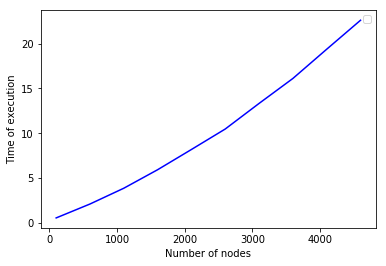

In [142]:
plot_execution_time_graph()